# Sentiment analysis
###### Oleksandr Panchenko

### Table of contents
1. Business problem 
2. Where we can find the data
3. How to collect the data
4. Data analysis

<hr style="height: 1px; background-color: #808080">

Sentiment analysis is a natural language processing problem that refers to the extraction or identifying the sentiment content of a text unit. The task may be interpreted as a binary classification task. Nevertheless, sometimes it might be useful to classify the reviews on three classes: positive, negative, neutral.

![](https://image.ibb.co/dS2kbQ/ezgif_1_d3df0c961a.gif)

Sentiment analysis helps the business to understand customers' opinions about the products or services that the business provides.


## Where we can find the data?
1. Websites parsing
    * Amazon
    * RottenTomatoes
    * IMDB
2. Open-source datasets
    * [IMDB movies dataset](https://sites.google.com/site/nquocdai/resources) - 234,000 reviews
    * [AMAZON goods](http://snap.stanford.edu/data/web-Amazon.html) - 34,686,770 reviews
    * [MovieLens Film Reviews](https://grouplens.org/datasets/movielens/) - 20,000,000 reviews
    * [Twitter](http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/) - 1,500,000 reviews

<hr style="height: 1px; background-color: #808080">

### Let's start parsing?
![](https://image.ibb.co/jvmWy5/memes1.png)

#### One remark before we start: READ TERMS OF USE BEFORE STARTING PARSING
![](https://image.ibb.co/b76LrQ/Screen_Shot_2017_04_12_at_20_43_18.png)

![](https://image.ibb.co/esr3BQ/13368226_original.jpg)

### How can we parse the data?

#### 1. Write your own parser
Let's look at the main page of the rottentomatoes.com website
![](https://image.ibb.co/hbsm0k/Screen_Shot_2017_04_14_at_17_32_08.png)
![](https://image.ibb.co/hX7EmQ/Screen_Shot_2017_04_14_at_21_13_04.png)
Here is a link to a service that provides a list with films
![](https://image.ibb.co/iyQTD5/Screen_Shot_2017_04_14_at_17_33_18.png)
Now let's look at the page with the reviews
![](https://image.ibb.co/j5Uc6Q/Screen_Shot_2017_04_14_at_17_37_07.png)
Let's also look at how pagination works
![](https://image.ibb.co/gmUoD5/Screen_Shot_2017_04_14_at_18_09_17.png)

In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import datetime
import pandas as pd


def log(msg):
    print(str(datetime.datetime.now()) + ' : ' + msg)

In [2]:
review_link = "https://www.rottentomatoes.com/m/{}/reviews/?type=user&page={}"
total_reviews = 0

def http_get(url):
    return BeautifulSoup(requests.get(url).text, 'html.parser')


def parse_single_reviews_page(soup, writer):
    review_divs = soup.find_all('div', {'class': 'col-xs-16'})
    for rd in review_divs:
        rating = len(rd.find_all('span', {'class': 'glyphicon-star'}))
        text = rd.find('div', {'class': 'user_review'}).getText().strip()
        half_point = rd.find('span', {'class': 'fl'})
        if half_point and len(half_point.getText().strip()) > 0:
            rating += 0.5
        writer.writerow({
            'label': rating,
            'text': text
        })
        global total_reviews
        total_reviews += 1
        if total_reviews % 100 == 0:
            log("Total reviews: " + str(total_reviews))


def parse_single_movie(movie_name, writer):
    current_page = 1
    soup = http_get(review_link.format(movie_name, current_page))
    parse_single_reviews_page(soup, writer)
    pages = soup.find('span', {'class': 'pageInfo'})
    if pages:
        page_num = int(pages.getText().split()[-1])
        while current_page < page_num:
            current_page += 1
            soup = http_get(review_link.format(movie_name, current_page))
            parse_single_reviews_page(soup, writer)

In [3]:
def get_movies_info(offset, limit):
    url = "http://rt-client-facade-v2-6-1.aws.prod.flixster.com/\
    movie?expand=true&filter=%7B%22country%22%3A%22UA%22%2C%22search\
    %22%3A%7B%22mpaa-rating-min%22%3A%22G%22%2C%22release-year-max%22%3A2017\
    %2C%22filter-release-date%22%3A%22false%22%2C%22offset%22%3A{}%2C%22\
    services%22%3A%5B%22amazon%22%2C%22hbo_go%22%2C%22itunes%22%2C%22\
    netflix_iw%22%2C%22vudu%22%2C%22amazon_prime%22%2C%22fandango_now%22%5D%2C%22\
    sort%22%3A%22DVD_RELEASE_DATE_DESC%22%2C%22distribution%22%3A%22ANY%22%2C%22\
    tomatometer-min%22%3A0%2C%22mpaa-rating-max%22%3A%22UN%22%2C%22release-day-of-month-max\
    %22%3A14%2C%22limit%22%3A{}%2C%22release-month-max%22%3A4%2C%22tomatometer-max\
    %22%3A100%2C%22use-dvd-date%22%3Atrue%2C%22status%22%3A%22LIVE%22%7D%7D".replace(" ", "").format(offset, limit)
    return requests.get(url).json()['data']

In [4]:
get_movies_info(0, 2)

[{'advisory': 'for brief nudity and some thematic elements',
  'creationDate': '2015-08-16T06:51:23-07:00',
  'id': '771423268',
  'lastModifiedDate': '2017-04-14T06:43:22-07:00',
  'movieBoxOfficeInfo': None,
  'mpaaRating': 'PG13',
  'title': 'Queen of the Desert',
  'tomatometer': {'state': 'rotten', 'value': 15},
  'type': 'movie',
  'vanity': 'queen_of_the_desert',
  'year': 2017},
 {'advisory': None,
  'creationDate': '2016-07-22T18:47:12-07:00',
  'id': '771446839',
  'lastModifiedDate': '2017-04-17T09:31:29-07:00',
  'movieBoxOfficeInfo': None,
  'mpaaRating': 'NR',
  'title': 'Sandy Wexler',
  'tomatometer': {'state': 'rotten', 'value': 33},
  'type': 'movie',
  'vanity': 'sandy_wexler',
  'year': 2017}]

In [5]:
MAX_MOVIES = 4 # 18448
offset = 0
limit = 10
enough = False
total_movies = 0

log("Start")
with open("parsed_data.csv", "a", encoding='utf-8') as f:
    writer = csv.DictWriter(f, ['label', 'text'])
    writer.writeheader()
    while total_movies <= MAX_MOVIES:
        movies_data = get_movies_info(offset, limit)
        for movie_data in movies_data:
            if total_movies > MAX_MOVIES:
                break;
            movie_title = movie_data['vanity']
            if movie_title:
                parse_single_movie(movie_title, writer)
            total_movies += 1
        offset += limit
log("Done")


2017-04-18 20:33:56.783141 : Start
2017-04-18 20:34:03.563579 : Total reviews: 100
2017-04-18 20:34:08.166518 : Total reviews: 200
2017-04-18 20:34:13.725555 : Total reviews: 300
2017-04-18 20:34:16.764639 : Done


In [9]:
parsed_df = pd.read_csv('parsed_data.csv')
parsed_df.head()

,label,text
0,3.5,I I would say that monster trucks very predict...
1,1.0,Horrible and boring and bad acting
2,3.0,Funny movie for the kid in yourself. Also a go...
3,5.0,Great movie for all. Good graphics and clean. ...
4,3.5,alien type et film... enjoyable


#### 2. Web widgets. 
Pros:
    * easy to use
    * no need to spend time on coding
Cons:
    * limited functionality
Example: [Web Scraper for Chrome](http://webscraper.io/)

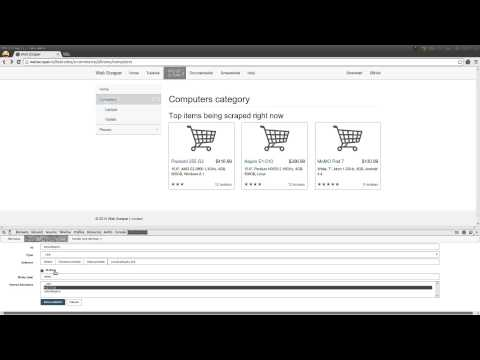

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo('y00t5NpW7pY')

## Data Analysis


In [11]:
from itertools import chain
from collections import Counter
PATH = '../data/movie_reviews.csv'
df = pd.read_csv(PATH)
# Let's take a look at our initial dataframe
df.head(25)

,label,text
0,1,"To an entire generation of filmgoers, it just ..."
1,1,Pixar classic is one of the best kids' movies ...
2,1,Apesar de representar um imenso avanço tecnoló...
3,1,"When Woody perks up in the opening scene, it's..."
4,1,Introduced not one but two indelible character...
5,1,it is easy to see how virtually everything tha...
6,1,Though some of the animation seems dated compa...
7,1,Perhaps the film is meant as a pre-emptive sop...
8,1,"Time has been kind to it, and future years I i..."
9,1,I think I speak for all adults and kids when I...


In [12]:
# Let's count the class balance
df.groupby('label').count()

,text
label,
0,62952
1,89658


In [13]:
# Mean length of the review
df["n_words"] = df.text.map(lambda x: len(str(x).split(" ")))
df["n_words"].mean()

86.91152611231243

In [14]:
# Top 10 most popolar words
Counter(chain.from_iterable(df.text.map(lambda x: str(x).split(" ")))).most_common(10)

[('the', 650599),
 ('a', 364399),
 ('and', 359062),
 ('of', 342897),
 ('to', 298630),
 ('is', 235123),
 ('in', 193845),
 ('that', 146420),
 ('I', 133470),
 ('this', 124605)]

In [15]:
(df["n_words"] < 4).mean() * 100

1.8832317672498526

In [16]:
((df["n_words"] > 3) & (df["n_words"] < 11)).mean() * 100

13.963698315968809

In [17]:
((df["n_words"] > 10) & (df["n_words"] < 51)).mean() * 100

52.238385426905189

In [18]:
(df["n_words"] > 50).mean() * 100

31.914684489876155

In [19]:
df.shape[0] - df.drop_duplicates().shape[0]

726

## Thank you for your attention
![](https://image.ibb.co/dmxdwQ/Screen_Shot_2017_04_15_at_01_23_55.png)